In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
from utils import *
from merge_utils import *

In [2]:
# df_trans1 = pd.read_csv('./data/test_transaction.csv')
# df_id1 = pd.read_csv('./data/test_identity.csv')

In [3]:
df_trans = pd.read_csv('./data/train_transaction.csv')
df_trans.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df_id = pd.read_csv('./data/train_identity.csv')
df_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [6]:
df_trans.rename({'isFraud':'label'}, axis=1, inplace=True)
df_id = df_id.merge(df_trans[['TransactionID', 'label']], on='TransactionID', how='left')

In [7]:
import pickle 
iv_dict = pickle.load(open('./result/iv_dict_trans.pkl', 'rb'))
iv_dict_id = pickle.load(open('./result/iv_dict_id.pkl', 'rb'))

In [8]:
iv_dict

{'TransactionID': (0.044101506272646605,
                            total     1      rate
  (2986999.999, 3046053.9]  59054  1631  0.027619
  (3046053.9, 3105107.8]    59054  1195  0.020236
  (3105107.8, 3164161.7]    59054  2200  0.037254
  (3164161.7, 3223215.6]    59054  2532  0.042876
  (3223215.6, 3282269.5]    59054  2336  0.039557
  (3282269.5, 3341323.4]    59054  2094  0.035459
  (3341323.4, 3400377.3]    59054  2550  0.043181
  (3400377.3, 3459431.2]    59054  2061  0.034900
  (3459431.2, 3518485.1]    59054  1851  0.031344
  (3518485.1, 3577539.0]    59054  2213  0.037474),
 'isFraud': (0.0,     total      1  rate
  0  569877      0   0.0
  1   20663  20663   1.0),
 'TransactionDT': (0.044101506272646605,
                            total     1      rate
  (86399.999, 1361004.4]    59054  1631  0.027619
  (1361004.4, 2310159.6]    59054  1195  0.020236
  (2310159.6, 3864163.9]    59054  2200  0.037254
  (3864163.9, 5592303.6]    59054  2532  0.042876
  (5592303.6, 7306527.5

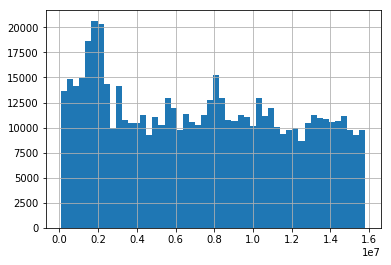

In [9]:
df_trans['TransactionDT'].hist(bins=50)

In [10]:
# 按时间分组
def splitMonth(data, day_nums=(31,31,28,31,30,31)):
    start_time = data['TransactionDT'].min()
    end_time = data['TransactionDT'].max()
    day = (data['TransactionDT']-start_time)//(86400)
    def encode_day(x):
        cumsum = 0
        for i in range(len(day_nums)):
            cumsum += day_nums[i]
            if x <= cumsum:
                return i
    data['#month'] = day.apply(encode_day)
splitMonth(df_trans)
df_trans['#month'].describe()

count    590540.000000
mean          2.258951
std           1.756788
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max           5.000000
Name: #month, dtype: float64

In [11]:
# 不同月份分布
count(df_trans, '#month')

(         total     1      rate
 #month                        
 0       139708  3601  0.025775
 1        94173  3817  0.040532
 2        86053  3464  0.040254
 3       100132  3903  0.038979
 4        85044  2884  0.033912
 5        85430  2994  0.035046, 0.030048868568672876)

In [67]:
list(df_trans.columns)

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V

In [119]:
class FeatureEncode:
    def __init__(self, label):
        self.label = label
        self.code_map_dict = dict()

    def replace_encode(self, data, f, cands):
        data['%s#encode' % f] = (data[f].isin(cands) * data[f]).replace(
            {cands[i]: (i + 1) for i in range(len(cands))})

    def merge_encode(self, data, f, tol, max_intervals, include_nan=False):
        if f not in self.code_map_dict:
            merge_value_lst = [x for x in highFreq(data, f, self.label, tol, plot=False)
                           if x != 999999]
            merge_value = {}
            for i in range(len(merge_value_lst)):
                if str(merge_value_lst[i]) == 'nan':
                    merge_value['nan'] = i
                else:
                    merge_value[merge_value_lst[i]] = i
            merge_idx = data[f].isin(merge_value) | data[f].isnull()
            data_tmp = data[[self.label, f]].copy()
            if include_nan:
                data_tmp[f].fillna('nan', inplace=True)
            data_tmp.loc[merge_idx, f] = data_tmp.loc[merge_idx, f].map(merge_value)
            intervals_info = chiMerge(data_tmp[merge_idx], f, self.label, max_intervals)
            count_table = data[[self.label, f]].groupby(f).agg(['count', 'sum'])[self.label]
            count_table['rate'] = count_table['sum']/count_table['count']
            code_map = {}
            if include_nan and 'nan' in merge_value:
                idx = merge_value['nan']
                for x in intervals_info:
                    if idx >= intervals_info[x]['bound'][0] and idx <= intervals_info[x]['bound'][1]:
                        code_map['nan'] = x
                        break
            for k, v in count_table.iterrows():
                if str(k) == 'nan':
                    k = 'nan'
                code = np.nan
                if k in merge_value:
                    idx = merge_value[k]
                    for x in intervals_info:
                        if idx >= intervals_info[x]['bound'][0] and idx <= intervals_info[x]['bound'][1]:
                            code = x
                            break
                else:
                    gap = {x: abs(v['rate']-intervals_info[x]['num'][1]/intervals_info[x]['num'][0])
                            for x in intervals_info}
                    code = sorted(gap, key=lambda x: gap[x])[0] if gap else np.nan
                code_map[k] = code
            self.code_map_dict[f] = code_map
        if include_nan:
            res = data[f].fillna('nan').map(self.code_map_dict[f])
        else:
            res = data[f].map(self.code_map_dict[f])
        return res

    def main_trans(self, data):
        n = data.shape[0]
        for col in ['ProductCD', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'] + \
            ['card%i'%i for i in range(1, 7)] + \
            ['M%i'%i for i in range(1, 10)]:
            data['%s#encode'%col] = self.merge_encode(data, col, 3000, 10)
    
    def main_id(self, data):
        for col in ['DeviceType', 'DeviceInfo'] + ['id_%i'%i for i in range(12, 39)]:
            data['%s#encode'%col] = self.merge_encode(data, col, 3000, 10, True)
        

In [51]:
E = FeatureEncode('label')
E.main_trans(df_trans)
with open('./result/code_map_dict_trans.pkl', 'wb') as f:
    pickle.dump(E.code_map_dict, f)
for x in df_trans.columns:
    if '#encode' in x:
        iv_dict[x] = count(df_trans, x, 10000)[::-1]

In [120]:
E = FeatureEncode('label')
E.main_id(df_id)
with open('./result/code_map_dict_id.pkl', 'wb') as f:
    pickle.dump(E.code_map_dict, f)
for x in df_id.columns:
    if '#encode' in x:
        iv_dict_id[x] = count(df_id, x, 10000)[::-1]
        print(iv_dict_id[x])

iv=0.0718
                     total       1      rate
DeviceType#encode                           
NaN                 3423.0   107.0  0.031259
desktop            85165.0  5554.0  0.065215
mobile             55645.0  5657.0  0.101662
iv=0.2891
                     total       1      rate
DeviceInfo#encode                           
Trident/7.0         7440.0    96.0  0.012903
MacOS              12573.0   278.0  0.022111
iOS Device         19782.0  1240.0  0.062683
Windows            47722.0  3121.0  0.065400
NaN                25567.0  2711.0  0.106035
999999             31149.0  3872.0  0.124306
iv=0.0127
               total      1      rate
id_12#encode                         
Found          21208   1269  0.059836
NotFound      123025  10049  0.081683
iv=0.0834
                total       1      rate
id_13#encode                           
NaN           16913.0   730.0  0.043162
49.0          26365.0  1761.0  0.066793
52.0          58099.0  4343.0  0.074752
999999.0      14713.0  

/Users/gaoming/PycharmProjects/FraudDetection/utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


iv=0.0000
                 total        1      rate
id_27#encode                             
999999            14.0      0.0  0.000000
NaN           139064.0  10892.0  0.078324
Found           5155.0    426.0  0.082638
iv=0.1379
                total       1      rate
id_28#encode                           
NaN            3255.0   100.0  0.030722
New           64746.0  3385.0  0.052281
Found         76232.0  7833.0  0.102752
iv=0.1514
                total       1      rate
id_29#encode                           
NaN            3255.0   100.0  0.030722
NotFound      66052.0  3391.0  0.051338
Found         74926.0  7827.0  0.104463
iv=0.3052
                total       1      rate
id_30#encode                           
Windows 10    21155.0   657.0  0.031056
Windows 7     13110.0   432.0  0.032952
iOS 11.1.2     3699.0   130.0  0.035145
iOS 11.2.1     3722.0   183.0  0.049167
999999        35879.0  2040.0  0.056858
NaN           66668.0  7876.0  0.118138
iv=0.2894
                    

(0.025631273319364403,                total     1      rate
id_37#encode                        
0               3248    96  0.029557
1              30533  2020  0.066158
2             110452  9202  0.083312)
(0.08478204273763007,               total     1      rate
id_38#encode                       
0              3248    96  0.029557
1             67063  3993  0.059541
2             73922  7229  0.097792)


In [63]:
# 初步建模尝试

In [127]:
list(df_trans.columns)

['TransactionID',
 'label',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65

In [122]:
id_features = searchRegex('.*#encode', df_id.columns)

In [125]:
df = df_trans.merge(df_id[['TransactionID']+id_features], on='TransactionID', how='left')
df.shape

(590540, 444)

In [130]:
tmp = list(df_trans.columns.drop(['TransactionID', 'label', 'TransactionDT', '#month']))
trans_features = []
for x in tmp:
    if '#' not in x:
        if '%s#encode'%x in tmp:
            trans_features.append('%s#encode'%x)
        else:
            trans_features.append(x)
trans_features

['TransactionAmt',
 'ProductCD#encode',
 'card1#encode',
 'card2#encode',
 'card3#encode',
 'card4#encode',
 'card5#encode',
 'card6#encode',
 'addr1#encode',
 'addr2#encode',
 'dist1',
 'dist2',
 'P_emaildomain#encode',
 'R_emaildomain#encode',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1#encode',
 'M2#encode',
 'M3#encode',
 'M4#encode',
 'M5#encode',
 'M6#encode',
 'M7#encode',
 'M8#encode',
 'M9#encode',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',

In [131]:
features = trans_features + id_features

In [ ]:
df_train_big = df[df['#month'] != 5]
df_train, df_test = split_data_v2(df_train_big, 0.2, 20190710)
df_test_oot = df[df['#month'] == 5]

In [136]:
params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'gamma': 0.1,                  
    'max_depth': 5,              
    'lambda': 0.2,                   
    'subsample': 0.7,           
    'colsample_bytree': 0.8,       
    'min_child_weight': 100,
    'reg_alpha': 0.3,
    'reg_lambda': 0.0,
    'scale_pos_weight': 9,
    'eta': 0.05,   
    'n_jobs': -1,                  
    'eval_metric': ['auc']
}
model, score = xgb_model_v2(params, df_train, df_test, df_test_oot, features, 'label', num_boost_round=200)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-auc:0.812469	val0-auc:0.812687	val1-auc:0.809697
Multiple eval metrics have been passed: 'val1-auc' will be used for early stopping.

Will train until val1-auc hasn't improved in 100 rounds.
[5]	train-auc:0.900924	val0-auc:0.899664	val1-auc:0.900503
[10]	train-auc:0.906933	val0-auc:0.905356	val1-auc:0.906293
[15]	train-auc:0.910739	val0-auc:0.909739	val1-auc:0.909519
[20]	train-auc:0.913644	val0-auc:0.911906	val1-auc:0.91062
[25]	train-auc:0.916027	val0-auc:0.914344	val1-auc:0.912447
[30]	train-auc:0.91858	val0-auc:0.916481	val1-auc:0.914358
[35]	train-auc:0.920702	val0-auc:0.91812	val1-auc:0.91656
[40]	train-auc:0.922981	val0-auc:0.920112	val1-auc:0.91871
[45]	train-auc:0.924318	val0-auc:0.921142	val1-auc:0.919745
[50]	train-auc:0.925994	val0-auc:0.922762	val1-auc:0.920873
[55]	train-auc:0.927279	val0-auc:0.923886	val1-auc:0.922066
[60]	train-auc:0.928497	val0-auc:0.924968	val1-auc:0.92296
[65]	train-auc:0.929838	val0-auc:0.926319	val1-auc:0.924021
[70]	train-auc:0.930982	va

In [141]:
df_trans1 = pd.read_csv('./data/test_transaction.csv')
df_id1 = pd.read_csv('./data/test_identity.csv')

In [143]:
E.main_id(df_id1)

In [145]:
E = FeatureEncode('label')
E.code_map_dict = pickle.load(open('./result/code_map_dict_trans.pkl', 'rb'))
E.main_trans(df_trans1)

In [146]:
df1 = df_trans1.merge(df_id1[['TransactionID']+id_features], on='TransactionID', how='left')
del df_trans1, df_id1
df1.to_csv('./data/test_code.csv', index=False)

In [148]:
df1['isFraud'] = model.predict(xgb.DMatrix(df1[features]))
df1[['TransactionID', 'isFraud']].to_csv('./result/submit_baseline.csv', index=False)